In [1]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import pandas as pd
import geopandas as gpd
from matplotlib import transforms
import re
from shapely.geometry import Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib


In [2]:
# Change this to where ever your data files are located
data_dir = "D:\Permanent Thesis Workspace\Final datasets of 3 sensors"
files = os.listdir(data_dir)

def planck_um(lam, T):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c1/(lam**5*(np.exp(c2/(lam*T))-1))

def inv_planck_um(lam, radiance):
    c1 = 1.191042*10**8
    c2 = 1.4387752*10**4
    return c2/(lam*np.log(c1/(lam**5*radiance)+1))

# Test functions
print(planck_um(11, 290), 'W/m2*sr*um should be ', 8.222077035769829,'W/m2*sr*um')
print(inv_planck_um(11, 1000), 'K should be ', 2362.5656807352184,'K')

8.222072203488061 W/m2*sr*um should be  8.222077035769829 W/m2*sr*um
2362.5793738804778 K should be  2362.5656807352184 K


In [3]:
# Extracting start and end times from defined image path
# When intputting file path,
#-----date, start-time, end-time, start date-time, end-time, and others are pulled from files that have '2019' in the name
def extract_start_end_datetime(file):
    date_index = file.find('2019')
    date = file[date_index:date_index+4]+"-"+file[date_index+4:date_index+6]+"-"+file[date_index+6:date_index+8]
    start_time = file[date_index+9: date_index+11]+":"+file[date_index+11:date_index+13]
    end_time = file[date_index+14: date_index+16]+":"+file[date_index+16:date_index+18]
    start_datetime = np.datetime64(date+"T"+start_time)
    end_datetime = np.datetime64(date+"T"+end_time)
    day_time = float(file[date_index+9: date_index+11])-7+float(file[date_index+11:date_index+13])/60
    return (start_datetime, end_datetime, day_time)

In [4]:
# The georeferenced images are the band_filenames list that is first down below

band_filenames = []
fdi_filenames = []
start_datetimes = []
day_times = []
end_datetimes = []
durations = []
flight_tracks = []

for file in files:
    if(file.endswith('Georeferenced_v02')):
        #print('bands',file)
        print('fdi',file+"_SWIRMask")
        #print(extract_start_end_datetime(file))
        (start_datetime, end_datetime, day_time) = extract_start_end_datetime(file)
        start_datetimes.append(start_datetime)
        end_datetimes.append(end_datetime)
        durations.append(end_datetime-start_datetime)
        band_filenames.append(file)
        fdi_filenames.append(file+"_SWIRMask")
        date_index = file.find('2019')
        flight_track = file[date_index-9:date_index-1]
        flight_tracks.append(flight_track)
        day_times.append(day_time)
        
df = pd.DataFrame({'flight_track':flight_tracks,'start_time':start_datetimes,'day_time':day_times, 'end_time':end_datetimes,
                   'duration':durations,'band_file':band_filenames, 'fdi_file':fdi_filenames})
df = df.sort_values('start_time')
df = df.reset_index(drop=True)

df['start_time']=df['start_time'].dt.tz_localize(tz='UTC')
df['start_time']=df['start_time'].dt.tz_convert(tz='US/Pacific')
df['end_time']=df['end_time'].dt.tz_localize(tz='UTC')
df['end_time']=df['end_time'].dt.tz_convert(tz='US/Pacific')


print(df)
print(df.dtypes)

fdi eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02_SWIRMask
  flight_track                start_time   day_time                  end_time  \
0     19910_10 2019-08-06 11:58:00-07:00  11.966667 2019-08-06 12:10:00-07:00   

  duration                                          band_file  \
0 00:12:00  eMASL1B_19910_10_20190806_1858_1910_V02_Georef...   

                                            fdi_file  
0  eMASL1B_19910_10_20190806_1858_1910_V02_Georef...  
flight_track                        object
start_time      datetime64[ns, US/Pacific]
day_time                           float64
end_time        datetime64[ns, US/Pacific]
duration                   timedelta64[ns]
band_file                           object
fdi_file                            object
dtype: object


In [5]:
def get_nonfire_neighbors(row, col, fdi):  #Takes in row, col, and fdi image
    nonfire_neighbors = []       
    (num_row, num_col) = fdi.shape         # Tuple is created consisting of # rows/columns based off of fdi image shape
 
    bound = 1                             # counter mechanism
    while(bound < 3):  # The 'bound < 2 part means that it will --- 
                                                       # ---not look more than 1 pixels away from the current fire pixel,
            
        for i in range(row-bound, row+bound + 1):   # for i in the range of the row bounds
            for j in range(col-bound, col+bound + 1):  # for j in the range of columns
                if(fdi[i,j] == 0):                   # if both values of col/rows is equal to zero
                    nonfire_neighbors.append((i,j))     # append it to nonfire_neighbors empty list
        bound += 1
    return nonfire_neighbors

In [6]:
fire_detect_data = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry",
                                             "dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon",
                                             "atmo_transmit","LfMIR","Lbkg", "Num_nonFire_background"])

fire_detect_data.crs = "EPSG:32611"
#row_df = pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
#score_df = pd.concat([score_df, row_df], ignore_index=True)
fire_times = []
fire_frps = []
fire_datasets = []
fire_rows = []
fire_cols = []
fire_LfMIR = []
fire_Lbackground = []

fire_detection_times = []
fire_detection_number = []
fire_total_FRP = []

num_fire_no_background = 0
num_fire_pixels = 0
for index, row in df.iterrows():
    fire_time = row['start_time']
    fire_end_time = row["end_time"]
    band_file = row['band_file']
    fdi_file = row['fdi_file']
    
    print(band_file)
    fp = data_dir+"/"+band_file
    raster = rio.open(fp)
    if(not raster.count == 37):
        continue
    transform = raster.transform
    
    band_data = raster.tags()
    wls = []
    for band in band_data.keys():
        band = band_data[band]
        #print(band)
        band = band.split(")")[4]
        band = band.split("(")[1]
        #print(band)
            
        wls.append(float(band))
    wls = sorted(wls)
  #  print(wls)
          
    band_data_array = raster.read()

    fp_fdi = data_dir+"/"+fdi_file
    raster_fdi = rio.open(fp_fdi)
    fdi_data_array = raster_fdi.read()[0]
    (row,col)=np.nonzero(fdi_data_array)

    fire_pixels = {}
    num_fire_pixels += len(row)
    for i in range(0, len(row)):
        row_ind = row[i]
        col_ind = col[i]
        fire_pixels[(row_ind, col_ind)] = get_nonfire_neighbors(row_ind, col_ind, fdi_data_array)

    MIR_ind = wls.index(2.382)
    #print(MIR_ind)
    TIR_ind = wls.index(10.995)
    a = 5.14782174e-09 # T**4 fit coefficient
    b = 3.96245043e-12  # T**5 fit coefficient
    epsilon = 0.8   # Assume a value for emissivity for T**5 FRP
    sigma = 5.67*10**(-8)
    A = 50*50 # Pixel area is 50x50  meters (18 x 18 due to stacking of realign images)
    atmo_transmit = 0.99735 # Atmospheric transmittance
    FRPs=[]
    
    fire_detection_times.append(fire_time)
    fire_detection_number.append(len(row))
    total_FRP = 0
    
    frp_data_array = np.zeros_like(fdi_data_array, dtype=float)
    
    #"dataset","row","col","FRP","FRP_T5","epsilon","LfMIR","Lbkg"
    fire_detect_start_times = []
    fire_detect_end_times = []
    fire_detect_xcoords = []
    fire_detect_ycoords = []
    fire_detect_nf_xcoords= []
    fire_detect_nf_ycoords= []
    fire_detect_number_nonfire_neighbors= []
    fire_detect_datasets = []
    fire_detect_rows = []
    fire_detect_cols = []
    fire_detect_FRPs = []
    fire_detect_FRP_T5s = []
    fire_detect_epsilons = []
    fire_detect_atmo_transmits = []
    fire_detect_LfMIRs = []
    fire_detect_Lbkgs = []
    fire_detect_FRP_ratios = []
    fire_detect_points = []
    
   # from 0 to 558 cells that are fire pixels
   # Basically for each fire pixel...do the following
    for i in range(0, len(row)):
        
        # creating row_col variables for each fire cell
        row_ind = row[i]
        col_ind = col[i]
        
        # creating fire_neighbors variable that has non-fire pixels position  
        fire_neighbors = fire_pixels[(row_ind, col_ind)]
        
        # the number of non-fire pixel neighbors
        num_fire_neighbors = len(fire_neighbors)
        fire_detect_number_nonfire_neighbors.append(num_fire_neighbors)
        
        # if there is 0 in the number of non-fire pixel neighbors, then create a num_fire_no_bacgrnd and add onto it for--
        #--------each loop
        if(num_fire_neighbors==0):
            num_fire_no_background+=1
            continue
       
        fire_detect_start_times.append(fire_time)
        fire_detect_end_times.append(fire_end_time)
        fire_detect_datasets.append(band_file)
        
        # appending the individual row/col variables within each loop to fire_Detect_rows/cols 
        fire_detect_rows.append(row_ind)
        fire_detect_cols.append(col_ind)
        #print(row_ind)
        #print(col_ind)
        
        # Then project the pixel positon points to x,y coordinates (to meteres)
        (x_coord, y_coord) = rio.transform.xy(raster.transform, row_ind, col_ind, offset="ul")
        
        # then append those x,y points to the empty list variables
        fire_detect_points.append(Point(x_coord, y_coord))
        fire_detect_xcoords.append(x_coord)
        fire_detect_ycoords.append(y_coord)
        fire_detect_epsilons.append(epsilon)
        fire_detect_atmo_transmits.append(atmo_transmit)
        
        # creating none value for radiance backrgound (L_background)
        # this value will accumulate the background radiance values from the loop down below
        #----then eventually the total will be divded to get an average background value
        L_background = 0
        
        # loop throgh row/col of fire neighbpors (they are in tuple format, thus (row_n,col_n))
        # if there is 13 values in fire_neighbors, it will loop through 13 times for example.
        for (row_n, col_n) in fire_neighbors:
            
            # convert backgground pixel positions to xy coordinates in meters
            (x_nf_coord, y_nf_coord) = rio.transform.xy(raster.transform, row_n, col_n, offset="ul")
            fire_detect_nf_xcoords.append(x_nf_coord)
            fire_detect_nf_ycoords.append(y_nf_coord)
            
            # retrieveing the value of the 24th band of the raster by getting its col/row position
            L_background += band_data_array[MIR_ind,row_n,col_n]
        
        # then divide the total accumnulated background radiance (L_background) by the number of pixels to get average value
        L_background = L_background / num_fire_neighbors

        # then calculate the total difference between the radiance value of the fire pixel and the average value of background
        LfMIR = (band_data_array[MIR_ind, row_ind, col_ind] - L_background) / atmo_transmit
        
        # then apply forumula of frp
        FRP = A*sigma*LfMIR/a
        FRP_T5 = A*sigma*epsilon**(1./5)*(LfMIR**(4./5))/(b**(4./5))
        FRPs.append(FRP)
        
        fire_detect_Lbkgs.append(L_background)
        fire_detect_LfMIRs.append(LfMIR)
        #print(FRP)
        fire_detect_FRPs.append(FRP)
        fire_detect_FRP_T5s.append(FRP_T5)
        fire_detect_FRP_ratios.append(FRP_T5/FRP)
        
        fire_times.append(fire_time)
        fire_frps.append(FRP)
        fire_datasets.append(band_file)
        fire_rows.append(row_ind)
        fire_cols.append(col_ind)
        
        fire_LfMIR.append(LfMIR)
        fire_Lbackground.append(L_background)
        total_FRP += FRP
        frp_data_array[row_ind, col_ind] = FRP
        
        
        fire_total_FRP.append(total_FRP)
    
    
    nonFire_detect_flighttrack = gpd.GeoDataFrame(columns=["X_coords", "Y_coords"])
    nonFire_detect_flighttrack['X_coords'] = fire_detect_nf_xcoords
    nonFire_detect_flighttrack['Y_coords'] = fire_detect_nf_ycoords
    
    print(len(fire_detect_start_times), len(fire_detect_FRPs))
    fire_detect_flighttrack = gpd.GeoDataFrame(columns=["start_time","end_time","x_coord","y_coord","geometry","dataset","row","col","FRP","FRP_T5","FRP_ratio","epsilon","atmo_transmit","LfMIR","Lbkg"])
    fire_detect_flighttrack["start_time"] = fire_detect_start_times
    fire_detect_flighttrack["end_time"] = fire_detect_end_times
    fire_detect_flighttrack["x_coord"] = fire_detect_xcoords
    fire_detect_flighttrack["y_coord"] = fire_detect_ycoords
    fire_detect_flighttrack["dataset"] = fire_detect_datasets
    fire_detect_flighttrack["row"] = fire_detect_rows
    fire_detect_flighttrack["col"] = fire_detect_cols
    fire_detect_flighttrack["FRP"] = fire_detect_FRPs
    fire_detect_flighttrack["FRP_T5"] = fire_detect_FRP_T5s
    fire_detect_flighttrack["FRP_ratio"] = fire_detect_FRP_ratios
    fire_detect_flighttrack["epsilon"] = fire_detect_epsilons
    fire_detect_flighttrack["atmo_transmit"] = fire_detect_atmo_transmits
    fire_detect_flighttrack["LfMIR"] = fire_detect_LfMIRs
    fire_detect_flighttrack["Lbkg"] = fire_detect_Lbkgs
    fire_detect_flighttrack["Num_nonFire_background"] = fire_detect_number_nonfire_neighbors
    
    s = gpd.GeoSeries(fire_detect_points)
    s.crs = "EPSG:32611"
    fire_detect_flighttrack['geometry'] = s
    
    # "FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"
    #,columns=["start_time","end_time","lat","lon","dataset","row","col","FRP","FRP_T5","epsilon","atmo_transmit","LfMIR","Lbkg"]
    #pd.DataFrame([[user_id, name, points, 0]], columns=["user_id","name","score","hints"])
    fire_detect_data = gpd.GeoDataFrame(pd.concat([fire_detect_data, fire_detect_flighttrack], ignore_index=True))
    
# ----------Exploratory statistics for fire radiance
print("Stats for fire pixels: ")
print("Number of fire pixels", len(fire_detect_LfMIRs))
print("\tMin radiance of fire", np.min(fire_detect_LfMIRs), "\n\tMax",np.max(fire_detect_LfMIRs))
print("\tMean radiance of fire", np.mean(fire_detect_LfMIRs))
print("\tStandard Deviation",np.std(fire_detect_LfMIRs))


# ----------Exploratory statistics for fire background radiance
print("Stats for fire-background pixels: ")
print("\tMin radiance of fire background", np.min(fire_detect_Lbkgs), "\n\tMax",np.max(fire_detect_Lbkgs))
print("\tMean radiance of fire background", np.mean(fire_detect_Lbkgs))
print("\tStandard Deviation of fire background",np.std(fire_detect_Lbkgs))


fire_detect_data.crs = "EPSG:32611"
print("\tfire pixels =",num_fire_pixels)
print("\tNon Fire pixels:", len(fire_detect_Lbkgs))
print("\tfire pixels with no non-fire neighbors=",num_fire_no_background)   
  

eMASL1B_19910_10_20190806_1858_1910_V02_Georeferenced_v02
211 211
Stats for fire pixels: 
Number of fire pixels 211
	Min radiance of fire 0.32559964125083674 
	Max 76.39089223125444
	Mean radiance of fire 5.29865935361756
	Standard Deviation 7.45193822653651
Stats for fire-background pixels: 
	Min radiance of fire background 0.22249999331931272 
	Max 1.838571378162929
	Mean radiance of fire background 0.9723961366277916
	Standard Deviation of fire background 0.3648999190490708
	fire pixels = 211
	Non Fire pixels: 211
	fire pixels with no non-fire neighbors= 0


In [7]:
print("Number of coordinate non-fire nackground pixels: ", len(fire_detect_nf_xcoords))
print("Number of unique coordinate non-fire background pixels:", len(np.unique(fire_detect_nf_xcoords)))

Number of coordinate non-fire nackground pixels:  4586
Number of unique coordinate non-fire background pixels: 87


In [22]:
# saving the DataFrame as a CSV file 
gfg_csv_data = nonFire_detect_flighttrack.to_csv('eMAS_bound3_backgroundpixels.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data)


CSV String:
 None


In [24]:
# saving the DataFrame as a CSV file 
gfg_csv_data = fire_detect_data.to_csv('eMAS_bound3_FRP.csv', index = True) 
print('\nCSV String:\n', gfg_csv_data)


CSV String:
 None


0      2019-08-06 11:58:00-07:00
1      2019-08-06 11:58:00-07:00
2      2019-08-06 11:58:00-07:00
3      2019-08-06 11:58:00-07:00
4      2019-08-06 11:58:00-07:00
                 ...            
206    2019-08-06 11:58:00-07:00
207    2019-08-06 11:58:00-07:00
208    2019-08-06 11:58:00-07:00
209    2019-08-06 11:58:00-07:00
210    2019-08-06 11:58:00-07:00
Name: start_time, Length: 211, dtype: object


<IPython.core.display.Javascript object>


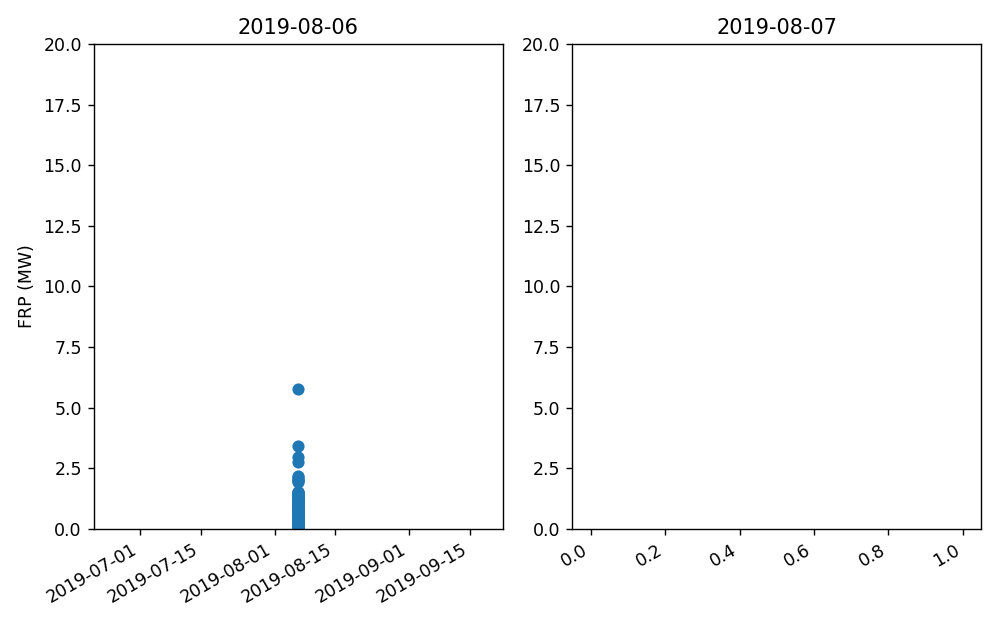

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [8]:
print(fire_detect_data["start_time"])
a = pd.to_datetime('2019-08-06T21').tz_localize('US/Pacific')
fire_detect_data["start_time"] < a

dates = ['2019-08-06','2019-08-07']
num_dates = len(dates)

fig, axs = plt.subplots(1, num_dates, figsize=(8,5))

for i in range(0, num_dates):
    date= dates[i]
    cutoff_max = pd.to_datetime(date+"T21").tz_localize('US/Pacific')
    cutoff_min = pd.to_datetime(date+"T01").tz_localize('US/Pacific')
    fire_on_date = fire_detect_data[(fire_detect_data["start_time"]>cutoff_min) & (fire_detect_data["start_time"]<cutoff_max)]
    axs[i].scatter(fire_on_date["start_time"], fire_on_date["FRP_T5"]/1e6)
    axs[i].set_ylim([0,20])
    axs[i].set_title(date)
axs[0].set_ylabel("FRP (MW)")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("WilliamsFlats_FirePixelFRP_T5.png")
plt.show()


[Timestamp('2019-08-06 11:58:00-0700', tz='US/Pacific')]


<IPython.core.display.Javascript object>


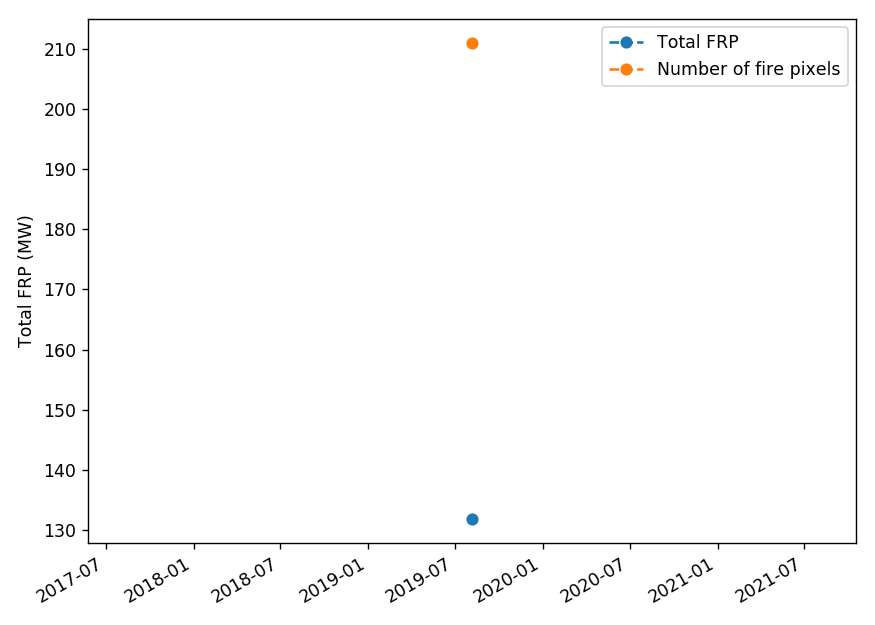

Total FRP [131.85499776455345]
Standard Deviation [0.6288561511303923]
Average FRP [0.6249052026756089]
Number of identified fire pixels [211]
Minimum 0.07309995764425498
Maximum 5.757093160156935


In [10]:
dates = ['2019-08-06','2019-08-07']
num_dates = len(dates)

unique_starttimes = fire_detect_data["start_time"].unique()
print(unique_starttimes)

fig, axs = plt.subplots(1, 1, figsize=(7,5))
total_FRPs = []
ave_FRPs = []
stdev_FRPs = []
num_fires = []
for i in range(0, len(unique_starttimes)):
    fire_at_time = fire_detect_data[fire_detect_data["start_time"] == unique_starttimes[i]]
    total_FRP = fire_at_time["FRP_T5"].sum()
    ave_FRP = fire_at_time["FRP_T5"].mean()
    stdev_FRP= fire_at_time["FRP_T5"].std()
    
    total_FRPs.append(total_FRP/1e6)
    ave_FRPs.append(ave_FRP/1e6)
    stdev_FRPs.append(stdev_FRP/1e6)
    num_fire = len(fire_at_time)
    num_fires.append(num_fire)

print("Total FRP", total_FRPs)
print("Standard Deviation", stdev_FRPs)
print("Average FRP", ave_FRPs)
print("Number of identified fire pixels", num_fires)
print("Minimum", np.min(fire_at_time["FRP_T5"]/1e6))
print("Maximum", np.max(fire_at_time["FRP_T5"]/1e6))
    
plt.plot(unique_starttimes, total_FRPs, '--o', label="Total FRP")
#plt.plot(unique_starttimes, ave_FRPs, '--o', label="Ave FRP")
plt.plot(unique_starttimes, num_fires, '--o', label="Number of fire pixels")

plt.legend()
axs.set_ylabel("Total FRP (MW)")
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("WilliamsFlats_TotalFRP_T5.png")
plt.show()


In [9]:
FRPs = []
for pix in fire_detect_FRP_T5s:
    new = pix/1e6
    FRPs.append(new)
print(len(FRPs))
print(len(fire_detect_LfMIRs))

211
211


In [10]:
x= pd.Series(FRPs)
y = pd.Series(fire_detect_LfMIRs)

print(x.corr(y))
print(x.corr(y, method='spearman')) 
print(x.corr(y, method='kendall'))

0.9889395273612361
1.0
1.0


In [11]:
import scipy.stats
slope, intercept ,r, p, stderr = scipy.stats.linregress(FRPs,fire_detect_LfMIRs)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

Regression line: y=-2.04+11.75x, r=0.99


<IPython.core.display.Javascript object>


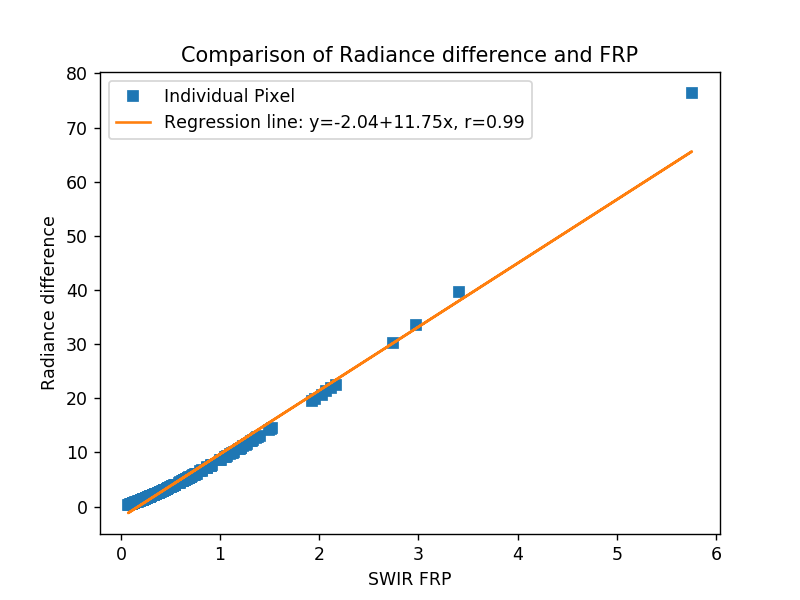

In [12]:
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Individual Pixel')
ax.plot(x, intercept + slope * x, label=line)
ax.set_title("Comparison of Radiance difference and FRP")
ax.set_xlabel('SWIR FRP')
ax.set_ylabel('Radiance difference')
ax.legend(facecolor='white')
plt.show()